In [334]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [335]:
# Load already clean data
df = pd.read_csv('Customer360InsightsCleaned.csv')
df.head()


,SessionStart,CustomerID,FullName,Gender,Age,CreditScore,MonthlyIncome,Country,State,City,...,OrderConfirmation,OrderConfirmationTime,PaymentMethod,SessionEnd,OrderReturn,ReturnReason,SessionDuration,SessionYear,SessionMonth,SessionDay
0,2019-01-01 02:42:00,1001,Brittany Franklin,1,57,769,7591.0,2,4,Dongguan,...,True,2019-01-01 03:02:00,0,2019-01-01 02:53:00,False,Unknown,11.0,2019,1,1
1,2019-01-02 20:35:00,1002,Scott Stewart,0,69,746,3912.0,2,13,Yantai,...,True,2019-01-02 20:58:00,2,2019-01-02 20:54:00,False,Unknown,19.0,2019,1,2
2,2019-01-04 03:11:00,1003,Elizabeth Fowler,0,21,769,7460.0,7,3,Birmingham,...,True,2019-01-04 03:40:00,0,2019-01-04 03:35:00,False,Unknown,24.0,2019,1,4
3,2019-01-05 09:01:00,1004,Julian Wall,0,67,631,4765.0,7,3,Birmingham,...,True,2019-01-05 09:26:00,0,2019-01-05 09:20:00,False,Unknown,19.0,2019,1,5
4,2019-01-05 13:35:00,1005,James Simmons,1,57,630,3286.8,2,13,Yantai,...,True,2019-01-05 13:52:00,2,2019-01-05 13:42:00,False,Unknown,7.0,2019,1,5


In [336]:
df['SessionStart'] = pd.to_datetime(df['SessionStart'])
df['SessionEnd'] = pd.to_datetime(df['SessionEnd'])

In [337]:
# Encode categorical variables
categorical_cols = df.select_dtypes(include=['object','category'])
categorical_cols.columns


Index(['FullName', 'City', 'Product', 'CampaignSchema ', 'CartAdditionTime',
       'OrderConfirmationTime', 'OrderReturn', 'ReturnReason'],
      dtype='object')

In [338]:
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

In [339]:
# Feature engineering
df['ProfitMargin'] = df['Price'] - df['Cost']
df['TotalRevenue'] = df['Price'] * df['Quantity']


In [340]:
df.columns

Index(['SessionStart', 'CustomerID', 'FullName', 'Gender', 'Age',
       'CreditScore', 'MonthlyIncome', 'Country', 'State', 'City', 'Category',
       'Product', 'Cost', 'Price', 'Quantity', 'CampaignSchema ',
       'CartAdditionTime', 'OrderConfirmation', 'OrderConfirmationTime',
       'PaymentMethod', 'SessionEnd', 'OrderReturn', 'ReturnReason',
       'SessionDuration', 'SessionYear', 'SessionMonth', 'SessionDay',
       'ProfitMargin', 'TotalRevenue'],
      dtype='object')

# Predicting Customer Churn


In [341]:
# Define churn [Criteria: no session in the last 6 months from the latest date in the data]
latest_date = df['SessionEnd'].max()
churn_cutoff = latest_date - pd.Timedelta(days=180)
df['Churn'] = np.where(df['SessionEnd'] < churn_cutoff, 1, 0)

In [342]:
df.head()

,SessionStart,CustomerID,FullName,Gender,Age,CreditScore,MonthlyIncome,Country,State,City,...,SessionEnd,OrderReturn,ReturnReason,SessionDuration,SessionYear,SessionMonth,SessionDay,ProfitMargin,TotalRevenue,Churn
0,2019-01-01 02:42:00,1001,165,1,57,769,7591.0,2,4,7,...,2019-01-01 02:53:00,0,4,11.0,2019,1,1,20,200,1
1,2019-01-02 20:35:00,1002,1029,0,69,746,3912.0,2,13,50,...,2019-01-02 20:54:00,0,4,19.0,2019,1,2,30,480,1
2,2019-01-04 03:11:00,1003,364,0,21,769,7460.0,7,3,4,...,2019-01-04 03:35:00,0,4,24.0,2019,1,4,8,40,1
3,2019-01-05 09:01:00,1004,605,0,67,631,4765.0,7,3,4,...,2019-01-05 09:20:00,0,4,19.0,2019,1,5,8,40,1
4,2019-01-05 13:35:00,1005,454,1,57,630,3286.8,2,13,50,...,2019-01-05 13:42:00,0,4,7.0,2019,1,5,40,600,1


In [343]:
# Create time-based features
df['DaysSinceLastSession'] = (latest_date - df['SessionEnd']).dt.days

In [344]:
# Define all potential features
all_features = ['Age', 'CreditScore', 'MonthlyIncome', 'ProfitMargin', 'SessionDuration', 'TotalRevenue', 'OrderReturn', 'DaysSinceLastSession',
                'Gender', 'Country', 'State', 'City', 'Category', 'Product', 'Quantity', 'PaymentMethod', 'CampaignSchema ']

# Calculate Mutual Information
X_all = df[all_features]
y = df['Churn']
mi_scores = mutual_info_classif(X_all.fillna(0).astype(str), y, discrete_features='auto')

# Select top 10-15 features based on mutual information
feature_importance_df = pd.DataFrame({'Feature': all_features, 'MI_Score': mi_scores}).sort_values(by='MI_Score', ascending=False)
selected_features = feature_importance_df['Feature'].head(15).tolist()
print("Selected Top Features:", selected_features)


Selected Top Features: ['DaysSinceLastSession', 'ProfitMargin', 'PaymentMethod', 'OrderReturn', 'Product', 'CreditScore', 'Category', 'City', 'Age', 'Gender', 'TotalRevenue', 'MonthlyIncome', 'SessionDuration', 'Country', 'State']


In [345]:
# Define X and y
X = df[selected_features]
y = df['Churn']
# Balance the dataset to 1810 samples per class
ros = RandomOverSampler(sampling_strategy={0: 1810, 1: 1810}, random_state=42)
X_res, y_res = ros.fit_resample(X, y)

# Add small noise to reduce model overfitting
noise = np.random.normal(0, 0.05, X_res.shape)
X_res = X_res + noise

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


RF:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC: 1.0
Confusion Matrix:
 [[342   0]
 [  0 382]]

LR:
Accuracy: 0.9820441988950276
Precision: 1.0
Recall: 0.9659685863874345
F1 Score: 0.9826897470039947
ROC AUC: 0.9998239490523866
Confusion Matrix:
 [[342   0]
 [ 13 369]]

DT:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC: 1.0
Confusion Matrix:
 [[342   0]
 [  0 382]]

ET:
Accuracy: 0.9861878453038674
Precision: 1.0
Recall: 0.9738219895287958
F1 Score: 0.986737400530504
ROC AUC: 0.9869109947643979
Confusion Matrix:
 [[342   0]
 [ 10 372]]

XGBoost:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC: 1.0
Confusion Matrix:
 [[342   0]
 [  0 382]]


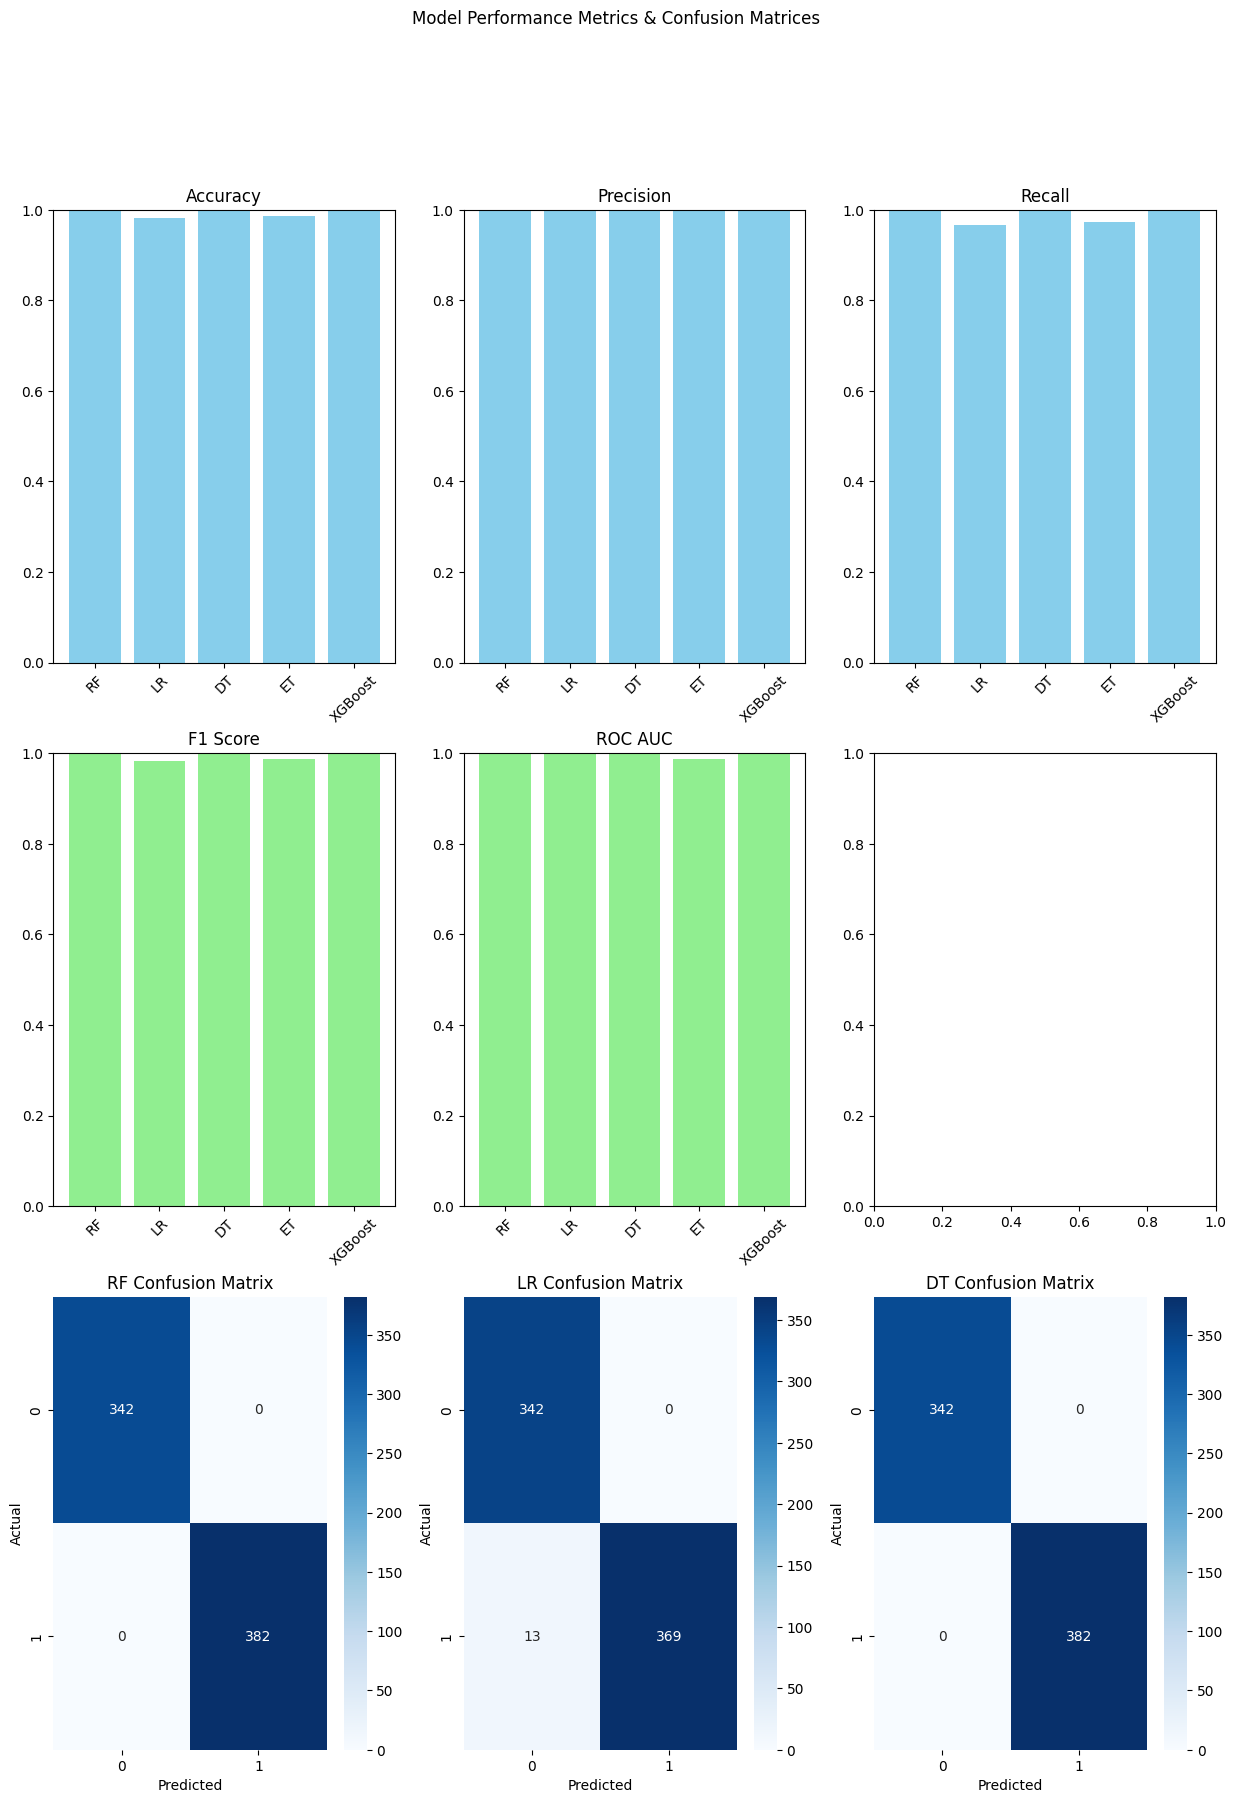

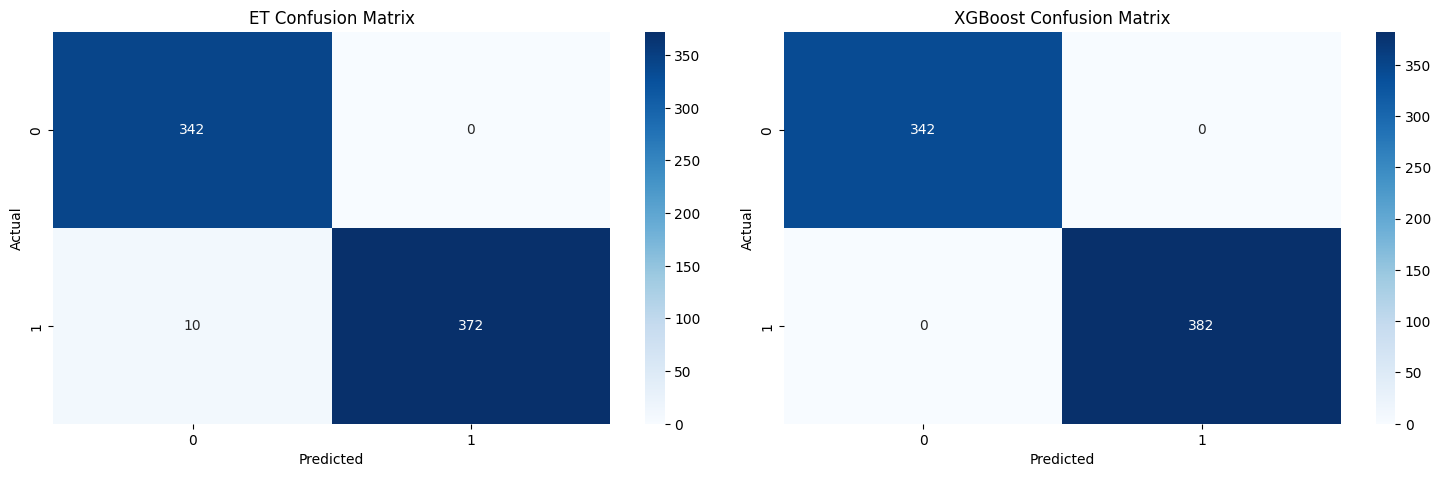


Performance Metrics Summary:
  Model  Accuracy  Precision   Recall  F1 Score  ROC AUC
     RF  1.000000        1.0 1.000000  1.000000 1.000000
     LR  0.982044        1.0 0.965969  0.982690 0.999824
     DT  1.000000        1.0 1.000000  1.000000 1.000000
     ET  0.986188        1.0 0.973822  0.986737 0.986911
XGBoost  1.000000        1.0 1.000000  1.000000 1.000000


In [348]:
# Define models
models = {
    "RF": RandomForestClassifier(n_estimators=100, random_state=42),
    "LR": LogisticRegression(max_iter=1000),
    "DT": DecisionTreeClassifier(random_state=42),
    "ET": ExtraTreeClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Train, predict, and evaluate each model
metrics = {"Model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1 Score": [], "ROC AUC": []}
conf_matrices = {}

for name, model in models.items():
    print(f"\n{name}:")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    conf_matrix = confusion_matrix(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("ROC AUC:", roc_auc)
    print("Confusion Matrix:\n", conf_matrix)

    # Store metrics
    metrics["Model"].append(name)
    metrics["Accuracy"].append(accuracy)
    metrics["Precision"].append(precision)
    metrics["Recall"].append(recall)
    metrics["F1 Score"].append(f1)
    metrics["ROC AUC"].append(roc_auc)
    conf_matrices[name] = conf_matrix

# Plot metrics
metrics_df = pd.DataFrame(metrics)
fig, axes = plt.subplots(3, 3, figsize=(15, 20))
fig.suptitle('Model Performance Metrics & Confusion Matrices')

for ax, metric in zip(axes[0], ["Accuracy", "Precision", "Recall"]):
    ax.bar(metrics_df['Model'], metrics_df[metric], color='skyblue')
    ax.set_title(metric)
    ax.set_xticklabels(metrics_df['Model'], rotation=45)
    ax.set_ylim(0, 1)

for ax, metric in zip(axes[1], ["F1 Score", "ROC AUC"]):
    ax.bar(metrics_df['Model'], metrics_df[metric], color='lightgreen')
    ax.set_title(metric)
    ax.set_xticklabels(metrics_df['Model'], rotation=45)
    ax.set_ylim(0, 1)

# Adjust confusion matrices layout to fit all five
for ax, (model_name, matrix) in zip(axes[2], conf_matrices.items()):
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f"{model_name} Confusion Matrix")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

# Add any remaining matrices if more than available subplots
if len(conf_matrices) > len(axes[2]):
    fig, extra_axes = plt.subplots(1, len(conf_matrices) - len(axes[2]), figsize=(15, 5))
    for ax, (model_name, matrix) in zip(extra_axes, list(conf_matrices.items())[len(axes[2]):]):
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(f"{model_name} Confusion Matrix")
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Display metrics as a table
print("\nPerformance Metrics Summary:")
print(metrics_df.to_string(index=False))
